In [231]:
# visualisation.py

import src.metrics
import importlib

importlib.reload(src.metrics)

import matplotlib.pyplot as plt
import numpy as np
from src.metrics import dice_coefficients, mask_accuracies


def plot_image_masks(image, mask, mask_pred):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].set_title("Input Image")
    ax[0].imshow(image, cmap="gray")
    ax[0].set_xticks([]), ax[0].set_yticks([])

    ax[1].set_title("Ground Truth")
    ax[1].imshow(mask, cmap="gray")
    ax[1].set_xticks([]), ax[1].set_yticks([])

    dsc = dice_coefficients(mask_pred, mask)
    accuracy = mask_accuracies(mask_pred, mask)

    ax[2].set_title(f"Predicted (DSC: {dsc:.2f}, Acc: {accuracy:.2f})")
    ax[2].imshow(mask_pred, cmap="gray")
    ax[2].set_xticks([]), ax[2].set_yticks([])

    plt.show()

In [277]:
# analysis.py --dataroot --predictions_dir --output_dir

import os
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# from src.arguments import parse_args


def parse_args(arg_string):
    parser = argparse.ArgumentParser()
    parser.add_argument("--dataroot", type=str, help="root directory of LCTSC dataset")
    parser.add_argument("--predictions_dir", type=str, help="directory containing the predictions (probabilities or masks) for each case")
    parser.add_argument("--metric_logger", type=str, help="file containing metric_logger")
    parser.add_argument("--output_dir", type=str, help="output directory")

    args = parser.parse_known_args(arg_string.split())[0]

    return args


args = parse_args("python analysis.py --dataroot ./Dataset --predictions_dir ./Predictions --metric_logger ./Models/metric_logger.pkl --output_dir ./Analysis")

In [233]:
##########
# Construct pandas dataframe with columns: Case, Slice, Accuracy, DSC, Mask Proportion, Image, Mask, Prediction
##########

# load the images, ground truth masks and mask probability predictions
# and calculate DSC and accuracy for all slices for all cases
train_cases = [f"Case_{i:03}" for i in range(1, 8)]
test_cases = [f"Case_{i:03}" for i in range(8, 12)]

data = []

for case in test_cases:
    images = np.load(os.path.join(args.dataroot, "Images", f"{case}.npz"))["images"]
    masks = np.load(os.path.join(args.dataroot, "Segmentations", f"{case}_seg.npz"))["masks"]
    probs = np.load(os.path.join(args.predictions_dir, f"{case}_pred.npz"))["probs"]
    accuracies = mask_accuracies(probs, masks)
    dscs = dice_coefficients(probs, masks)
    mask_proportions = masks.sum(axis=(1, 2)) / (512 * 512)  # proportion of mask pixels in each slice

    for i in range(len(images)):
        data.append(["test", case, i, accuracies[i], dscs[i], mask_proportions[i], images[i], masks[i], probs[i]])

# same for training cases
for case in train_cases:
    images = np.load(os.path.join(args.dataroot, "Images", f"{case}.npz"))["images"]
    masks = np.load(os.path.join(args.dataroot, "Segmentations", f"{case}_seg.npz"))["masks"]
    probs = np.load(os.path.join(args.predictions_dir, f"{case}_pred.npz"))["probs"]
    accuracies = mask_accuracies(probs, masks)
    dscs = dice_coefficients(probs, masks)
    mask_proportions = masks.sum(axis=(1, 2)) / (512 * 512)  # proportion of mask pixels in each slice

    for i in range(len(images)):
        data.append(["train", case, i, accuracies[i], dscs[i], mask_proportions[i], images[i], masks[i], probs[i]])

df = pd.DataFrame(data, columns=["Set", "Case", "Slice Index", "Accuracy", "DSC", "Mask Size", "Image", "Mask", "Prediction"])

test_filter = df["Set"] == "test"
train_filter = df["Set"] == "train"

In [234]:
# calculate mean DSC and accuracy for the train and test sets
mean_dsc_test = df[test_filter]["DSC"].mean()
mean_accuracy_test = df[test_filter]["Accuracy"].mean()
mean_dsc_train = df[train_filter]["DSC"].mean()
mean_accuracy_train = df[train_filter]["Accuracy"].mean()

print(f"Mean DSC (test): {mean_dsc_test:.4f}")
print(f"Mean Accuracy (test): {mean_accuracy_test:.4f}")
print(f"Mean DSC (train): {mean_dsc_train:.4f}")
print(f"Mean Accuracy (train): {mean_accuracy_train:.4f}")

Mean DSC (test): 0.5288
Mean Accuracy (test): 0.9983
Mean DSC (train): 0.5273
Mean Accuracy (train): 0.9988


In [235]:
# First we split the test set into a dataframe where we have no ground truth mask, and where we do have a ground truth mask
df_no_mask = df[test_filter][df[test_filter]["Mask Size"] == 0]
df_mask = df[test_filter][df[test_filter]["Mask Size"] > 0]

# proportion of slices with no mask
proportion_no_mask = len(df_no_mask) / len(df[test_filter])

# propotion of slices with no mask that have perfect accuracy
proportion_no_mask_perfect_accuracy = len(df_no_mask[df_no_mask["Accuracy"] == 1]) / len(df_no_mask)

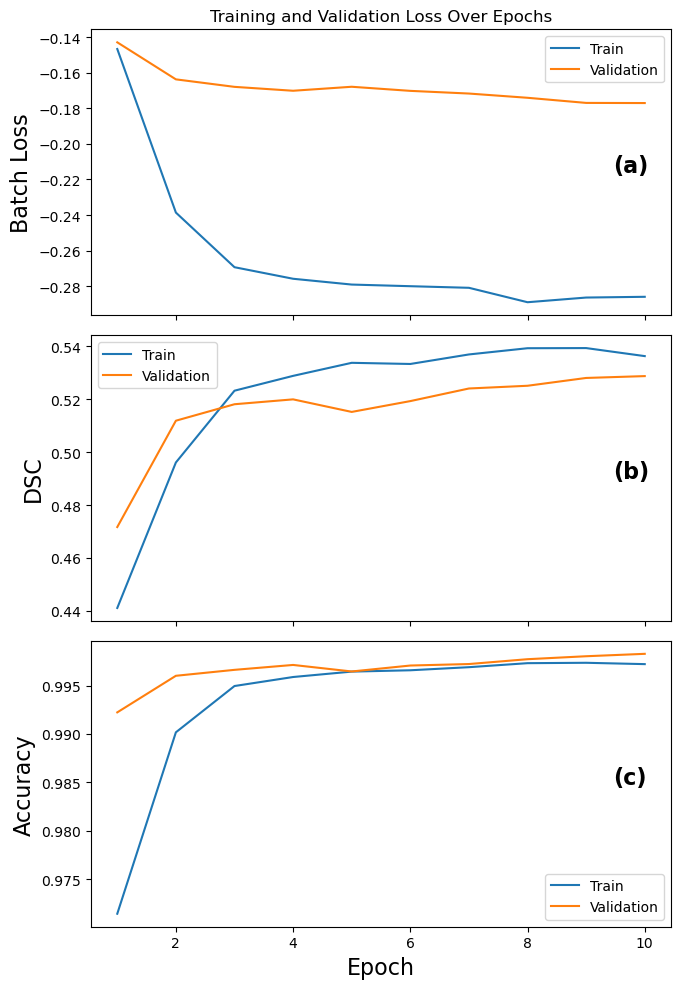

In [288]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

with open(args.metric_logger, "rb") as f:
    metric_logger = pickle.load(f)

n_epochs = len(metric_logger["Loss"]["train"])
epochs = np.arange(1, n_epochs + 1)

fig, ax = plt.subplots(3, 1, figsize=(7, 10))
ax[0].plot(epochs, metric_logger["Loss"]["train"], label="Train")
if metric_logger["Loss"]["test"]:
    ax[0].plot(epochs, metric_logger["Loss"]["test"], label="Validation")
ax[0].set_xlabel("")
ax[0].set_xticklabels("")
ax[0].set_ylabel("Batch Loss", fontsize=16)
ax[0].set_title("Training and Validation Loss Over Epochs")
ax[0].text(0.9, 0.5, "(a)", fontsize=16, transform=ax[0].transAxes, fontweight="bold")
ax[0].legend()

# Add subplot for 'DSC'
ax[1].plot(epochs, metric_logger["DSC"]["train"], label="Train")
if metric_logger["DSC"]["test"]:
    ax[1].plot(epochs, metric_logger["DSC"]["test"], label="Validation")
ax[1].set_xlabel("")
ax[1].set_xticklabels("")
ax[1].set_ylabel("DSC", fontsize=16)
ax[1].text(0.9, 0.5, "(b)", fontsize=16, transform=ax[1].transAxes, fontweight="bold")
ax[1].legend()

# Add subplot for 'Accuracy'
ax[2].plot(epochs, metric_logger["Accuracy"]["train"], label="Train")
if metric_logger["Accuracy"]["test"]:
    ax[2].plot(epochs, metric_logger["Accuracy"]["test"], label="Validation")
ax[2].set_xlabel("Epoch", fontsize=16)
ax[2].set_ylabel("Accuracy", fontsize=16)
ax[2].text(0.9, 0.5, "(c)", fontsize=16, transform=ax[2].transAxes, fontweight="bold")
ax[2].legend()

plt.tight_layout()
plt.show()

/Users/willknott/miniconda3/envs/dis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/willknott/miniconda3/envs/dis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/willknott/miniconda3/envs/dis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/willknott/miniconda3/envs/dis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

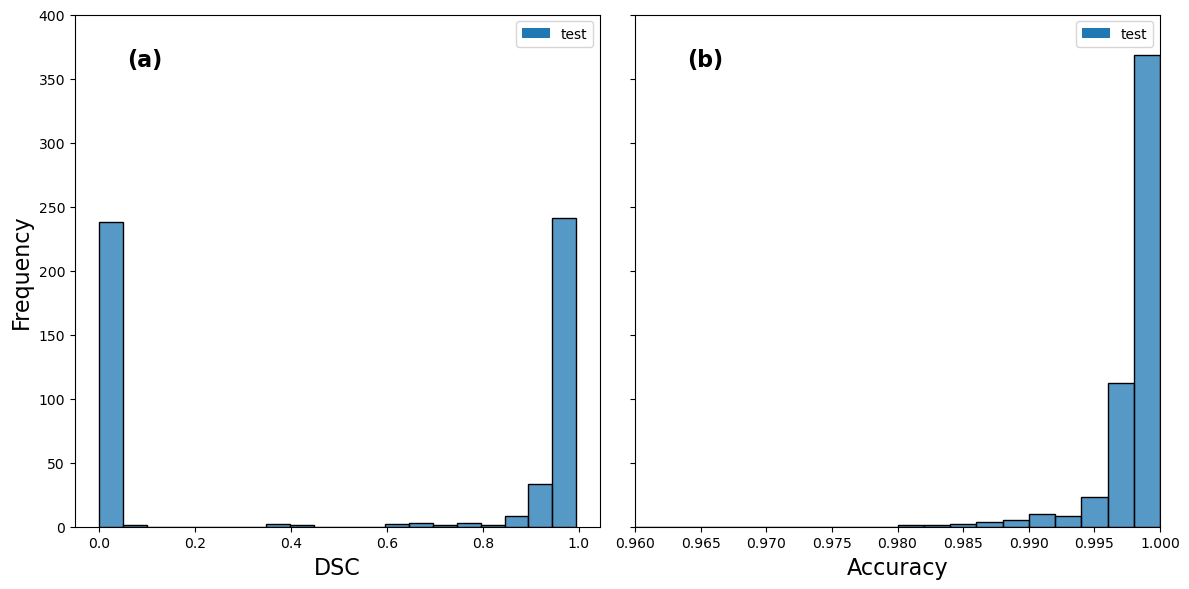

In [236]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df, test_filter, and train_filter are defined elsewhere in your code.

# Histograms of DSC and Accuracy for test set
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(df[test_filter]["DSC"], bins=20, ax=ax[0])
ax[0].set_ylabel("Frequency", fontsize=16)
ax[0].set_ylim(0, 400)
ax[0].set_xlabel("DSC", fontsize=16)
ax[0].legend(["test"])
ax[0].text(0.1, 0.9, "(a)", fontsize=16, transform=ax[0].transAxes, fontweight="bold")

bins = np.linspace(0.96, 1.0, 21)
sns.histplot(df[test_filter]["Accuracy"], bins=bins, ax=ax[1])
ax[1].set_ylabel("")
ax[1].set_xlabel("Accuracy", fontsize=16)
ax[1].set_yticklabels([])
ax[1].set_ylim(0, 400)
ax[1].legend(["test"])
ax[1].set_xlim(0.96, 1.0)  # Setting limits for Accuracy
ax[1].text(0.1, 0.9, "(b)", fontsize=16, transform=ax[1].transAxes, fontweight="bold")

plt.tight_layout()

fig.savefig(os.path.join(args.output_dir, "test-hist.png"))

/Users/willknott/miniconda3/envs/dis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/willknott/miniconda3/envs/dis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/willknott/miniconda3/envs/dis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/willknott/miniconda3/envs/dis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

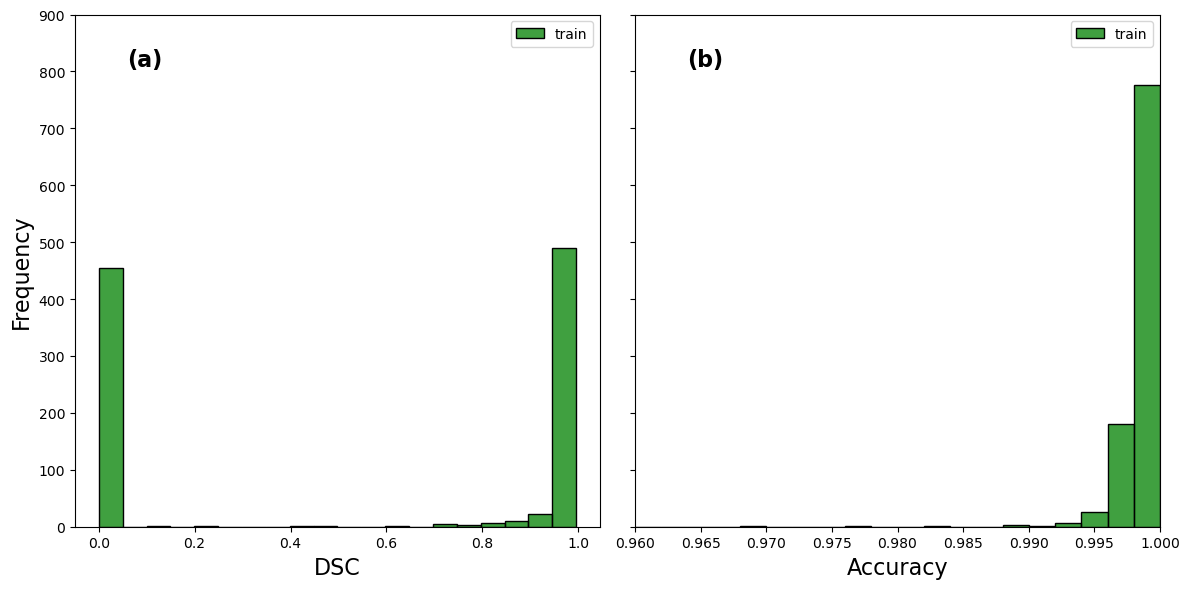

In [237]:
# Histograms of DSC and Accuracy for train set
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(df[train_filter]["DSC"], bins=20, ax=ax[0], color="g")
ax[0].set_ylabel("Frequency", fontsize=16)
ax[0].set_ylim(0, 900)
ax[0].set_xlabel("DSC", fontsize=16)
ax[0].legend(["train"])
ax[0].text(0.1, 0.9, "(a)", fontsize=16, transform=ax[0].transAxes, fontweight="bold")

bins = np.linspace(0.96, 1.0, 21)
sns.histplot(df[train_filter]["Accuracy"], bins=bins, ax=ax[1], color="g")
ax[1].set_ylabel("")
ax[1].set_xlabel("Accuracy", fontsize=16)
ax[1].set_yticklabels([])
ax[1].set_ylim(0, 900)
ax[1].legend(["train"])
ax[1].set_xlim(0.96, 1.0)  # Setting limits for Accuracy
ax[1].text(0.1, 0.9, "(b)", fontsize=16, transform=ax[1].transAxes, fontweight="bold")

plt.tight_layout()
fig.savefig(os.path.join(args.output_dir, "train-hist.png"))

/Users/willknott/miniconda3/envs/dis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/willknott/miniconda3/envs/dis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/willknott/miniconda3/envs/dis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


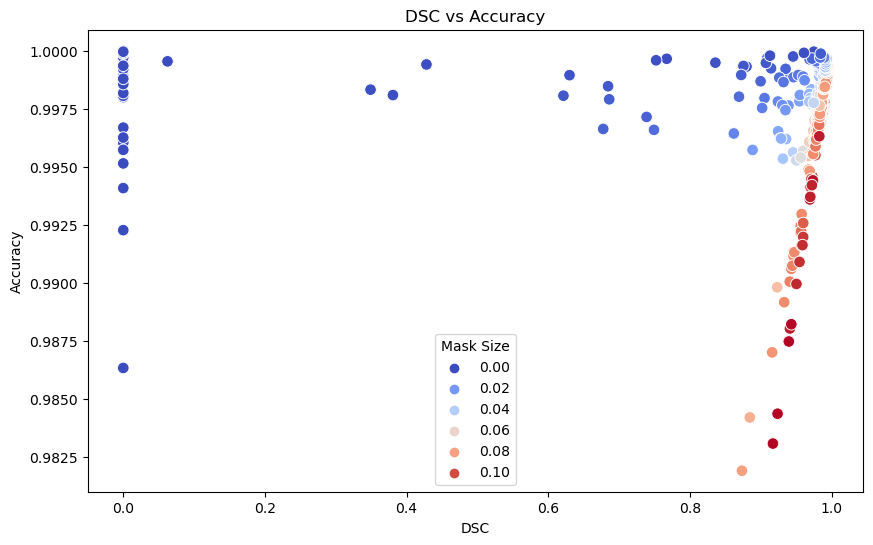

In [238]:
# scatter plot of DSC vs Accuracy, colour indicates 'Mask Proportion' (proportion of the image which is the mask)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.scatterplot(x="DSC", y="Accuracy", hue="Mask Size", data=df[test_filter], palette="coolwarm", ax=ax, marker="o", s=70)
ax.set_title("DSC vs Accuracy")
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)

fig.savefig(os.path.join(args.output_dir, "test_set_scatterplot.png"))

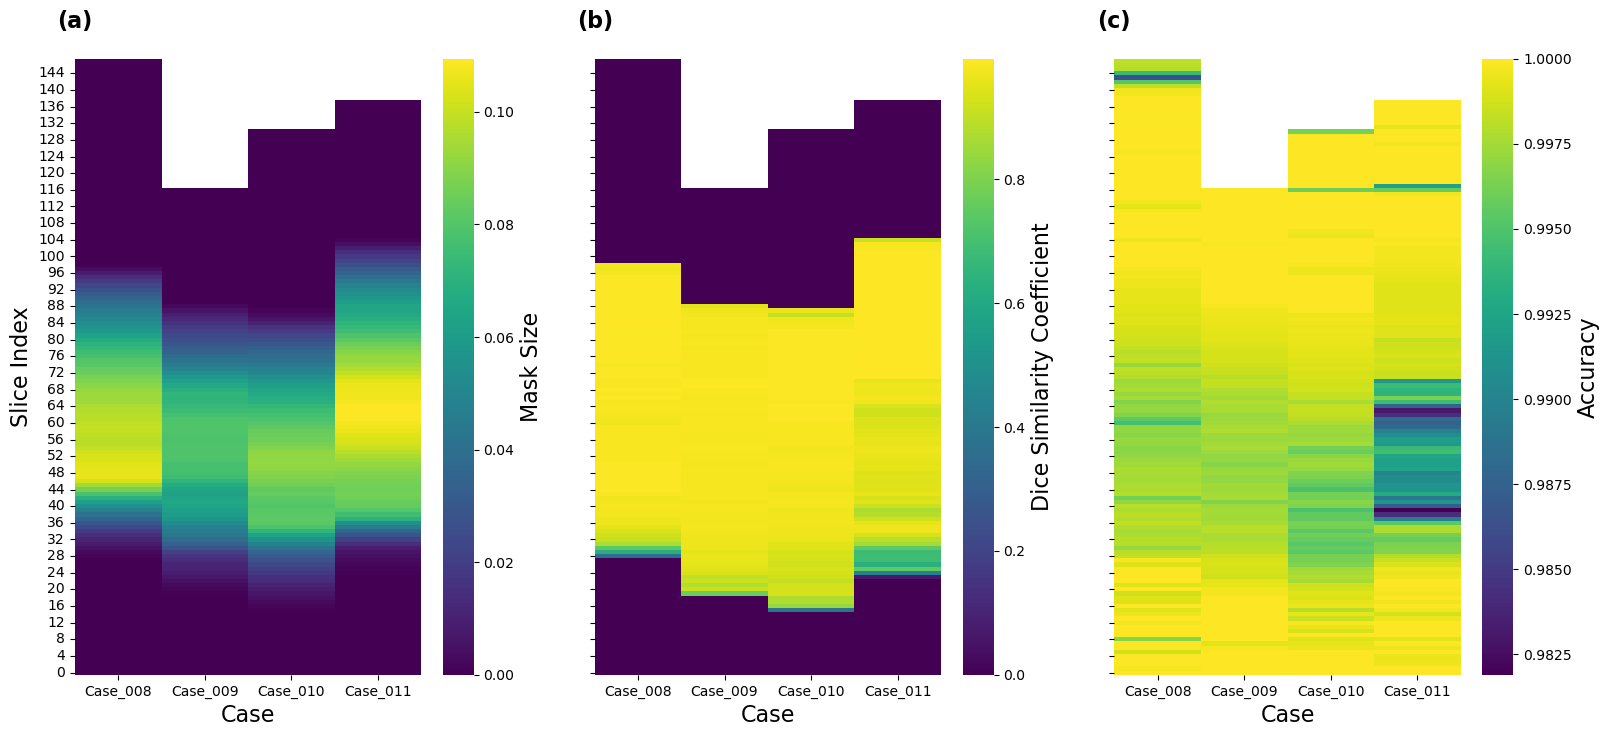

In [290]:
# Heatmaps: Slice on y-axis, case number on x-axis, colour re-presenting DSC
fig, ax = plt.subplots(1, 3, figsize=(19, 8))
sns.heatmap(df[test_filter].pivot(index="Slice Index", columns="Case", values="Mask Size"), cmap="viridis", ax=ax[0])
ax[0].set_ylabel("Slice Index", fontsize=16)
ax[0].invert_yaxis()
ax[0].set_xlabel("Case", fontsize=16)
ax[0].text(-0.05, 1.05, "(a)", fontsize=16, transform=ax[0].transAxes, fontweight="bold")
cbar = ax[0].collections[0].colorbar
cbar.set_label("Mask Size", fontsize=16)

sns.heatmap(df[test_filter].pivot(index="Slice Index", columns="Case", values="DSC"), cmap="viridis", ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_yticklabels([])
ax[1].set_ylabel("")
ax[1].set_xlabel("Case", fontsize=16)
ax[1].text(-0.05, 1.05, "(b)", fontsize=16, transform=ax[1].transAxes, fontweight="bold")
cbar = ax[1].collections[0].colorbar
cbar.set_label("Dice Similarity Coefficient", fontsize=16)

sns.heatmap(df[test_filter].pivot(index="Slice Index", columns="Case", values="Accuracy"), cmap="viridis", ax=ax[2])
ax[2].invert_yaxis()
ax[2].set_yticklabels([])
ax[2].set_ylabel("")
ax[2].set_xlabel("Case", fontsize=16)
ax[2].text(-0.05, 1.05, "(c)", fontsize=16, transform=ax[2].transAxes, fontweight="bold")
cbar = ax[2].collections[0].colorbar
cbar.set_label("Accuracy", fontsize=16)

fig.savefig(os.path.join(args.output_dir, "heatmaps.png"))

# Visualisation of masks

### Existing ground truth mask

In [246]:
def plot_rows(df):
    fig, ax = plt.subplots(len(df), 4, figsize=(12, 3 * len(df)))
    plt.subplots_adjust(wspace=0, hspace=0)

    for i, (_, row) in enumerate(df.iterrows()):
        image = row["Image"]
        mask = row["Mask"]
        prediction = (row["Prediction"] > 0.5).astype(np.uint8)
        case = row["Case"]
        slice_idx = row["Slice Index"]
        dsc = dice_coefficients(prediction, mask)
        accuracy = mask_accuracies(prediction, mask)

        if i == 0:
            ax[i, 0].set_title("Input Image")
            ax[i, 1].set_title("Ground Truth")
            ax[i, 2].set_title("Prediction")
            ax[i, 3].set_title("Metrics")

        ax[i, 0].imshow(image, cmap="gray")
        ax[i, 1].imshow(mask, cmap="gray")
        ax[i, 2].imshow(prediction, cmap="gray")

        text_box = ax[i, 3].text(
            0.5,
            0.5,
            f"{case} slice {slice_idx}\n\nMask: {not (mask==0).all()}\n\nDSC: {dsc:.4f}\nAcc: {accuracy:.4f}",
            fontsize=13,
            ha="center",
            va="center",
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
        )

        ax[i, 0].axis("off"), ax[i, 1].axis("off"), ax[i, 2].axis("off"), ax[i, 3].axis("off")
        ax[i, 3].set_aspect("equal")

    plt.tight_layout()

    return fig

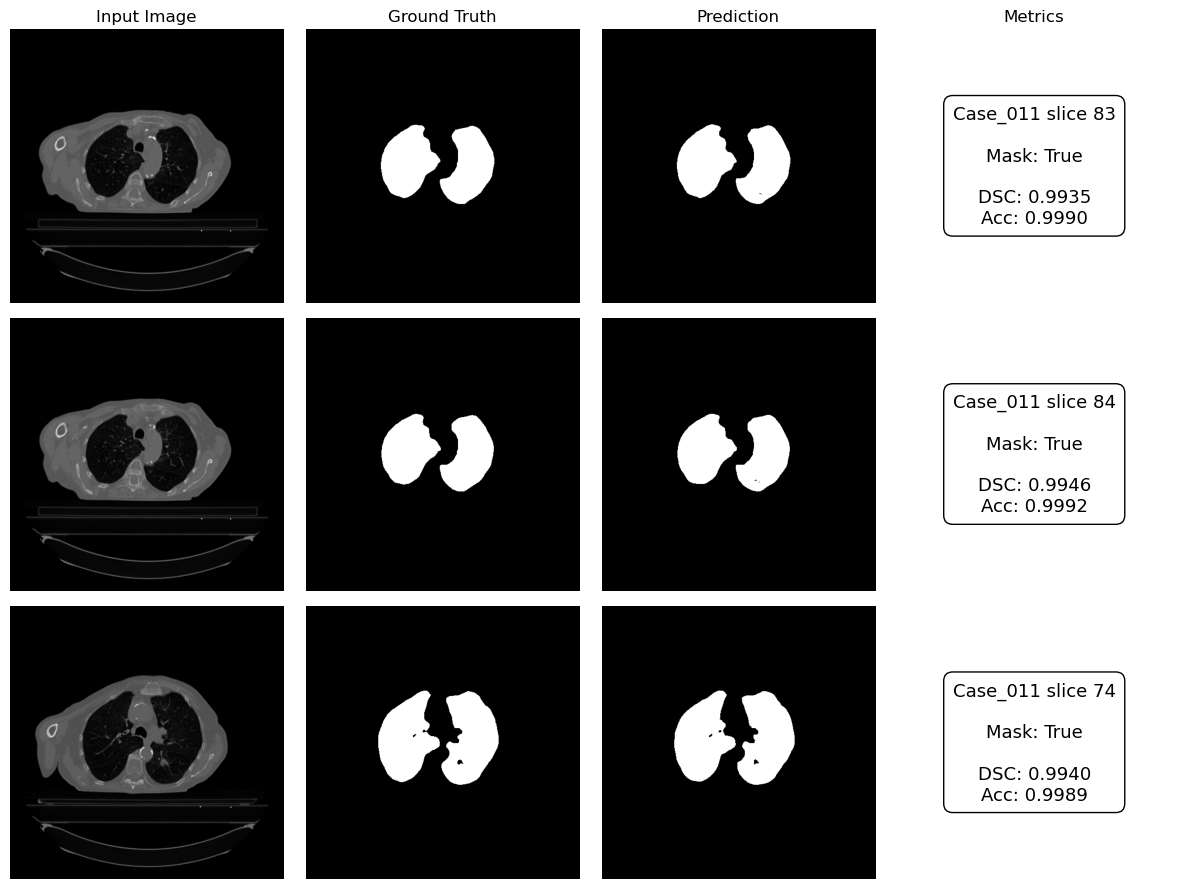

In [274]:
from torchvision.utils import make_grid

# best DSC
best = df[test_filter].sort_values("DSC", ascending=False).head(10)

fig = plot_rows(best.sample(3, random_state=42))
fig.savefig(os.path.join(args.output_dir, "best-dsc.png"))

intermediate
- one or more case 011 where DSC is intermediate, accuracy is (relatively) low
- 

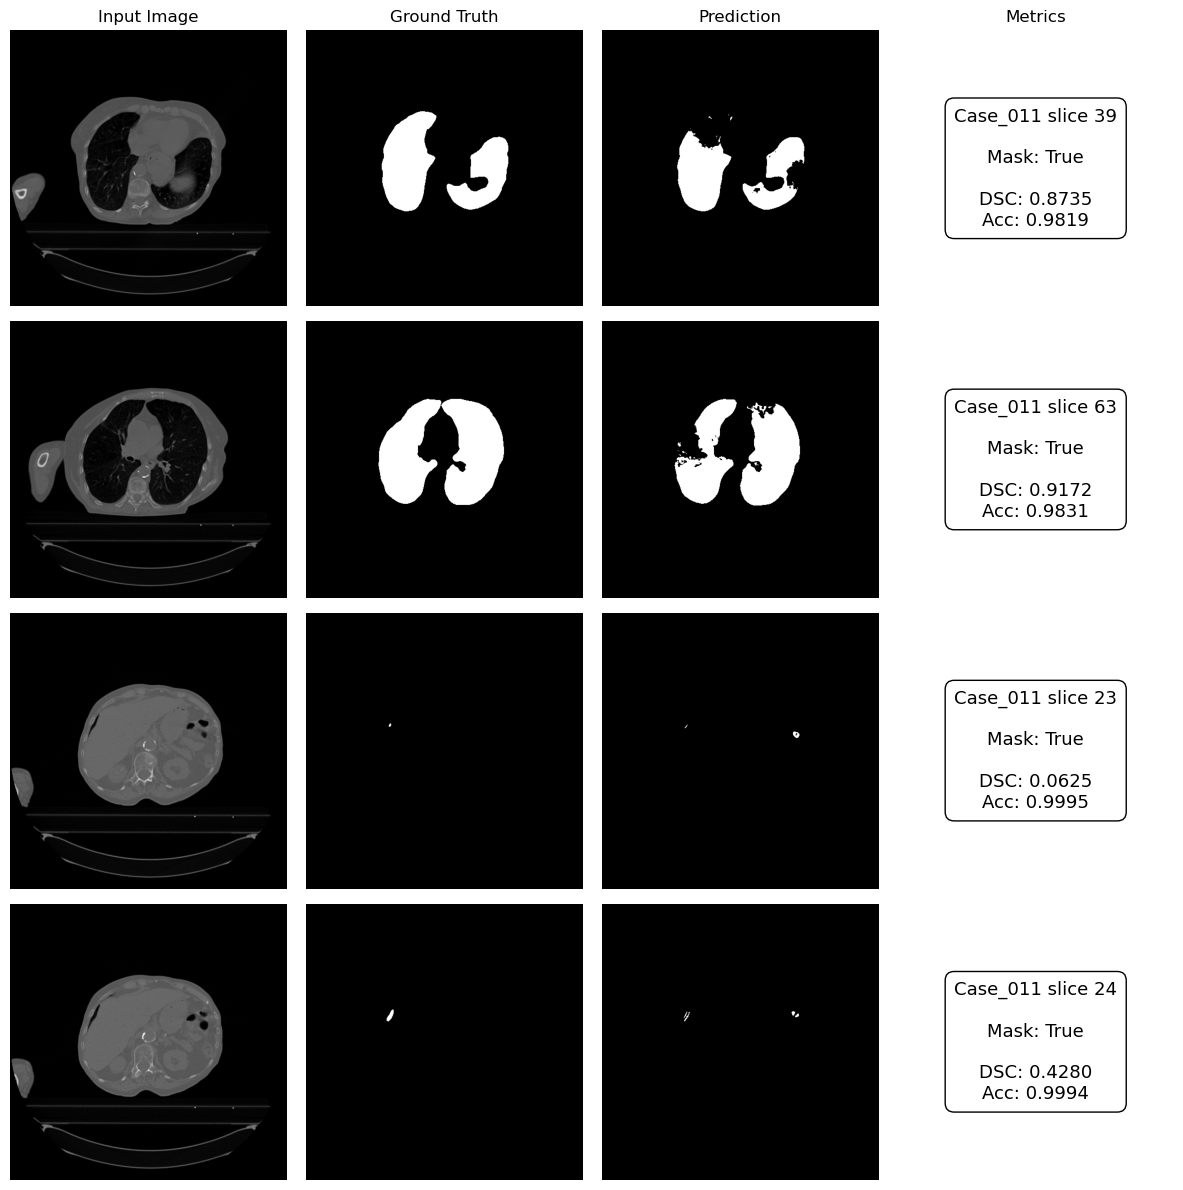

In [275]:
lowest_acc = df_mask.sort_values("Accuracy").head(2)
interval = df_mask[(df_mask["DSC"] > 0.0) & (df_mask["DSC"] < 0.6)].sample(2, random_state=0)
intermediate = pd.concat([lowest_acc, interval])

fig = plot_rows(intermediate)
fig.savefig(os.path.join(args.output_dir, "intermediate-dsc.png"))

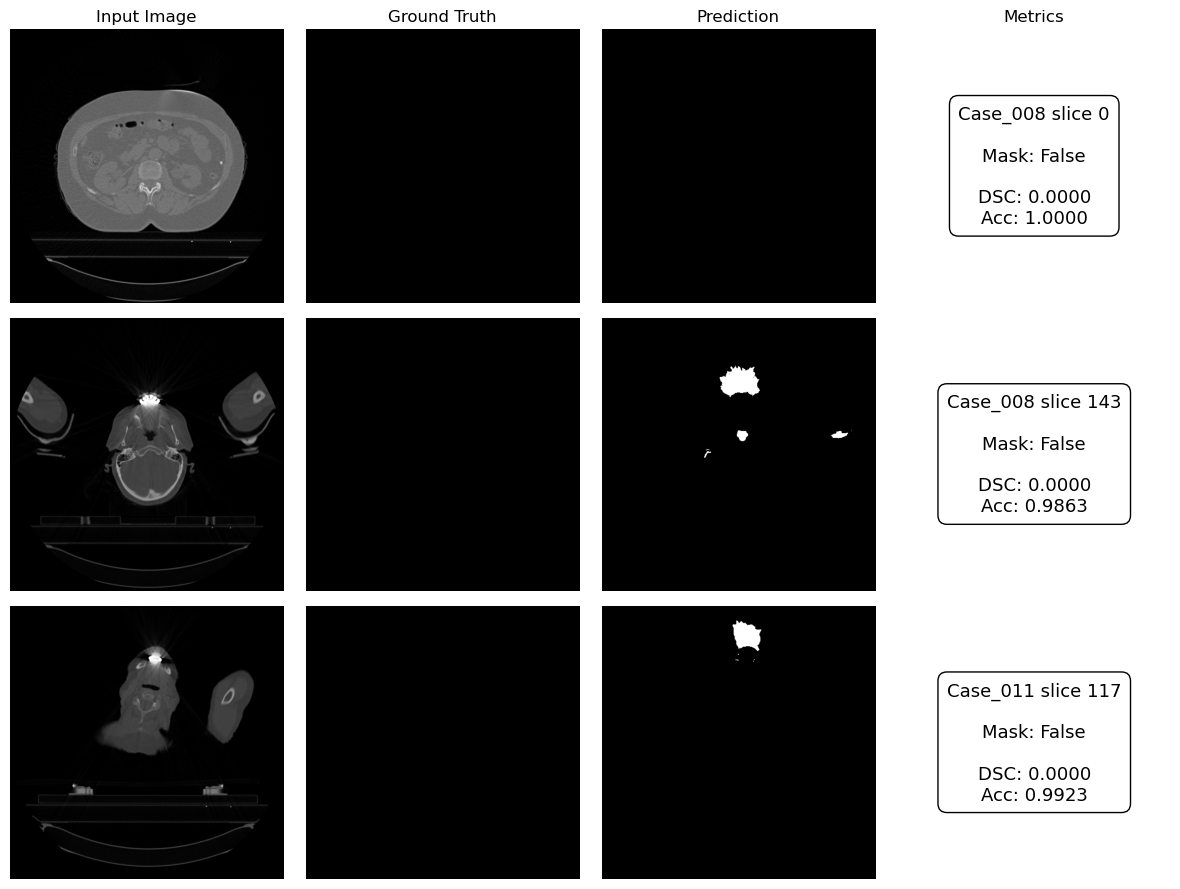

In [276]:
perf_no_mask = df_no_mask.sort_values("Accuracy", ascending=False).head(1)
worst_accuracy_no_mask = df_no_mask.sort_values("Accuracy").head(2)

# concatenate the two dataframes
no_mask = pd.concat([perf_no_mask, worst_accuracy_no_mask])

fig = plot_rows(no_mask)
fig.savefig(os.path.join(args.output_dir, "no-mask.png"))

# Model analysis

In [ ]:
# ###########
# # Model analysis
# ###########

# # plot precision-recall curve
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import average_precision_score
# from sklearn.metrics import auc

# masks = np.stack(df[test_filter]['Mask'].to_numpy()).flatten()
# probs = np.stack(df[test_filter]['Prediction'].to_numpy()).flatten()

In [ ]:
# precision, recall, _ = precision_recall_curve(masks, probs)

In [ ]:
# AUC = auc(recall, precision)

# # save the plots
# fig, ax = plt.subplots()
# ax.step(recall, precision, color='b', alpha=0.2, where='post')
# ax.fill_between(recall, precision, step='post', alpha=0.2, color='b')
# ax.set_xlabel('Recall')
# ax.set_ylabel('Precision')
# ax.set_ylim([0.0, 1.05])
# ax.set_xlim([0.0, 1.05])
# ax.set_title(f'Precision-Recall curve: AUC={AUC}')


# # save figure
# fig.savefig(os.path.join(args.output_dir, 'precision_recall_curve.png'))